In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

import glob
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import os

from funcs_query import query

from specdb.specdb import SpecDB, IgmSpec
from astropy.io import fits

In [114]:
def power_law(x,alpha,beta):
    return alpha*x**beta

lpath = '/media/bartosz/USB STICK/BOSS_DR14_ext/'

# power law parameters
lpl = np.loadtxt(lpath + 'power_law_fits_spline_rsq_cl_bound.txt', dtype='str')
plidx = [int(i) for i in lpl[:,0]]
lCs = [float(a) for a in lpl[:,2]]
lalphas = [float(b) for b in lpl[:,4]]

def find_dir(idx):
    lpath = '/media/bartosz/USB STICK/BOSS_DR14_ext/'
    sf2 = glob.glob(lpath + 'spectra_2_3/' + '{}_*.txt'.format(idx))
    sf3 = glob.glob(lpath + 'spectra_3_4/' + '{}_*.txt'.format(idx))
    sf1 = glob.glob(lpath + 'spectra_07_2/' + '{}_*.txt'.format(idx))
    if len(sf2) > 0: 
        specf = 'spectra_2_3/'
    elif len(sf3) > 0:
        specf = 'spectra_3_4/'
    elif len(sf1) > 0:
        specf = 'spectra_07_2/'
    else: print('eBOSS spec path could not be found')
    return specf


def plot_nfit(idx,fig,ax,lw,pl,c):

    filename = glob.glob(lpath + find_dir(idx) + 'fits/{}_*_0_dpx25.txt'.format(idx))[0]
    fit = np.loadtxt(filename)

    fit_wl = fit[:,0]
    fit_flux = fit[:,1]

    C = lCs[plidx.index(idx)]
    alpha = lalphas[plidx.index(idx)]

    lymask = fit_wl > 1216
    zeromask = fit_flux != 0
    comask = np.logical_and(lymask,zeromask)
    
    xdata = fit_wl[comask]
    if pl:
        ydata = fit_flux[comask] - power_law(xdata,C,alpha)
    elif not pl:
        ydata = fit_flux[comask]
    
    ax.plot(xdata,ydata ,linewidth=lw, color=c, drawstyle='steps-mid', alpha=0.6)
    
    mask1 = xdata > 1250
    mask2 = xdata < 2250
    mask = np.logical_and(mask1,mask2)
    return min(ydata[mask]),max(ydata[mask])


def plot_ndata(idx,fig,ax,lw,pl,c):
    filename = glob.glob(lpath + find_dir(idx) + 'normed/{}_*_norm.txt'.format(idx))[0]
    norm = np.loadtxt(filename)
    
    norm_wl = norm[:,0]
    norm_flux = norm[:,1]

    C = lCs[plidx.index(idx)]
    alpha = lalphas[plidx.index(idx)]

    xdata = norm_wl
    if pl:
        ydata = norm_flux - power_law(xdata,C,alpha)
    elif not pl:
        ydata = norm_flux
    
    ax.plot(xdata[:-50],ydata[:-50],linewidth=lw, drawstyle='steps-mid', color=c, alpha=0.5)
    mask1 = xdata > 1250
    mask2 = xdata < 2250
    mask = np.logical_and(mask1,mask2)
    return min(ydata[mask]),max(ydata[mask])

    
def func(z):
    def func2(x):
        return x*(1+z)
    return func2

def inv(z):
    def inv2(x):
        return x/(1+z)
    return inv2

In [57]:
from collections import Counter
import itertools

nn_file = np.loadtxt('/media/bartosz/USB STICK/BOSS_DR14_ext/nearest_neighbors_PLcorr.txt')
nn_q = nn_file[:,1]
nn_idx = nn_file[:,2:7]
nn_ds = nn_file[:,8:13]

# Nested list
nested_list = nn_idx

# Flatten the nested list
flat_list = list(itertools.chain.from_iterable(nested_list))

# Count the frequency of each number
number_counts = Counter(flat_list)

# Get the top 10 most common numbers
topx = number_counts.most_common(5)

print("Top 10 most occurring numbers and their counts:")
for number, count in topx:
    print(f"Number: {number}, Count: {count}")


Top 10 most occurring numbers and their counts:
Number: 372445.0, Count: 94
Number: 439311.0, Count: 93
Number: 338193.0, Count: 89
Number: 250188.0, Count: 87
Number: 366969.0, Count: 85


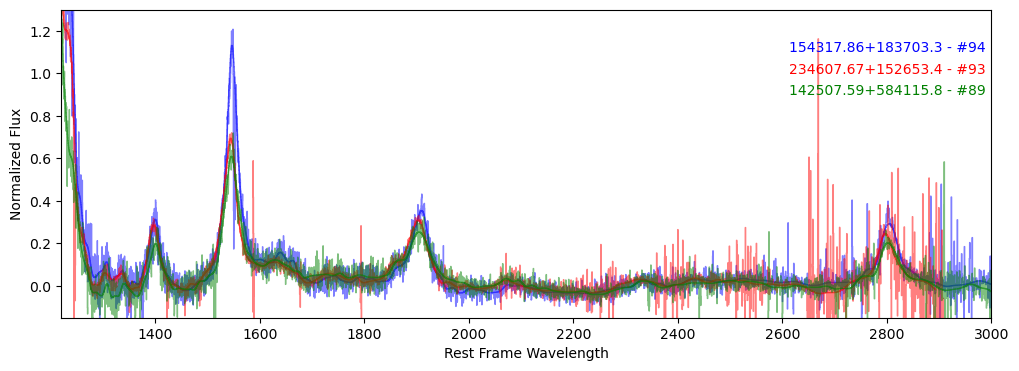

In [115]:
fig = plt.figure(figsize=(12, 4))
ax=fig.subplots()
qnames=['154317.86+183703.3',
'234607.67+152653.4',
'142507.59+584115.8',
'115544.71+131650.9',
'152755.21+292101.3']

colors=['blue','red','green','cyan','violet']

# plot_ndata(int(topx[0][0]),fig,ax,1,True)

i=0
for number, count in topx:
    plot_ndata(int(number),fig,ax,1,True,colors[i])
    plot_nfit(int(number),fig,ax,1,True,colors[i])
    ax.text(2990,1.1-i/10,'{} - #{}'.format(qnames[i],count),color=colors[i],ha='right')
    i+=1
    if i==3:break

plt.xlim(1220,3000)
plt.ylim(-0.15,1.3)
plt.xlabel('Rest Frame Wavelength')
plt.ylabel('Normalized Flux')
# plt.savefig('plots/add_plots/top3neighbors.pdf',bbox_inches='tight')
plt.show()
plt.close()

In [38]:
nn_dmeans = [np.mean(r) for r in nn_ds]

# Get the sorted indices based on the corresponding values in the array
sorted_indices = sorted(range(len(nn_dmeans)), key=lambda i: nn_dmeans[i])

print("Sorted indices based on corresponding values:")
# print(sorted_indices)

nn_dmeans_sorted = np.array(nn_dmeans)[sorted_indices]
nn_idx_sorted = np.array(nn_idx)[sorted_indices]
nn_q_sorted = np.array(nn_q)[sorted_indices]

nn_dmeans_sorted[-10:]

Sorted indices based on corresponding values:


array([154.76387577, 164.7096821 , 176.94512732, 202.83554651,
       234.55654386, 254.16141837, 337.49033074, 404.34920719,
       537.08753331, 694.85901411])

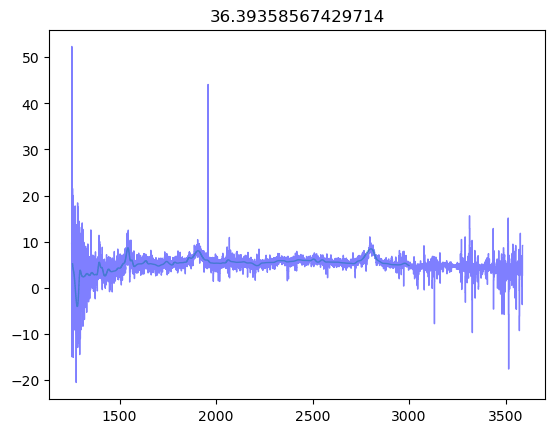

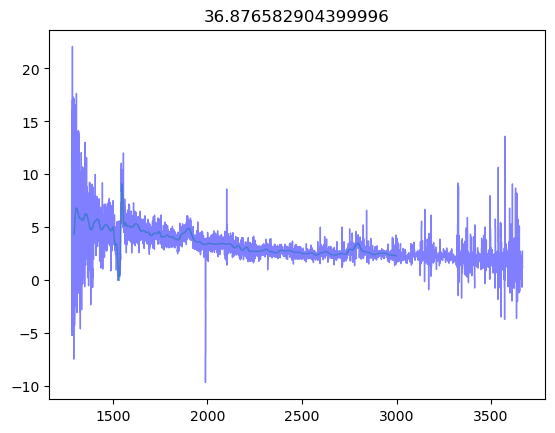

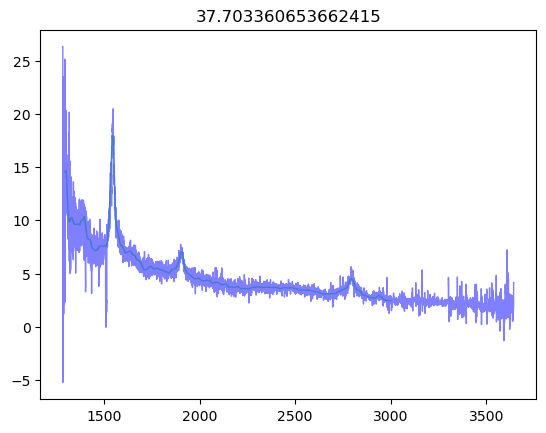

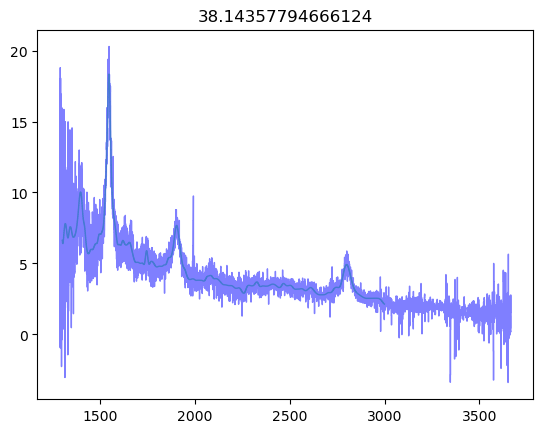

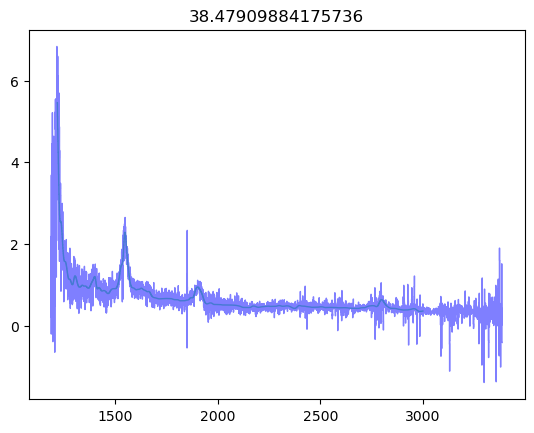

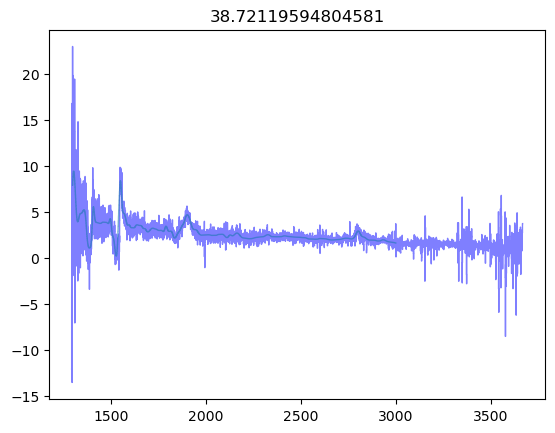

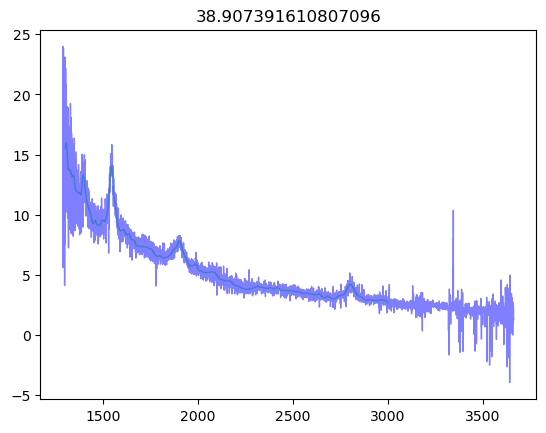

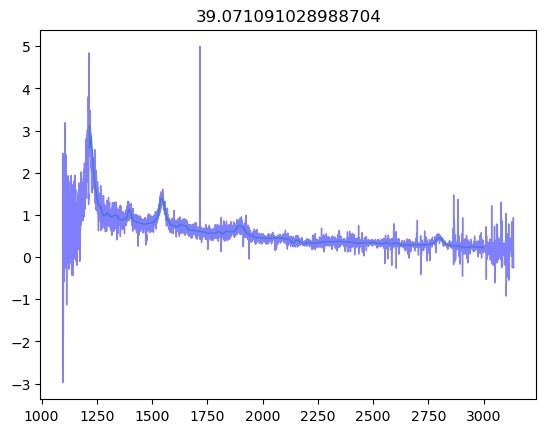

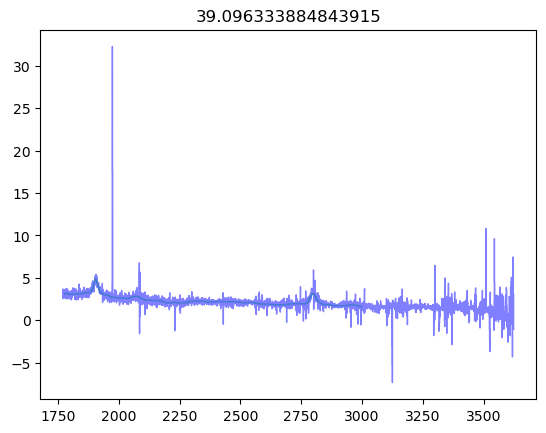

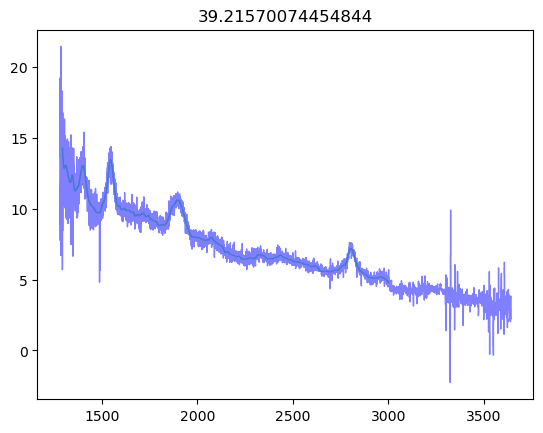

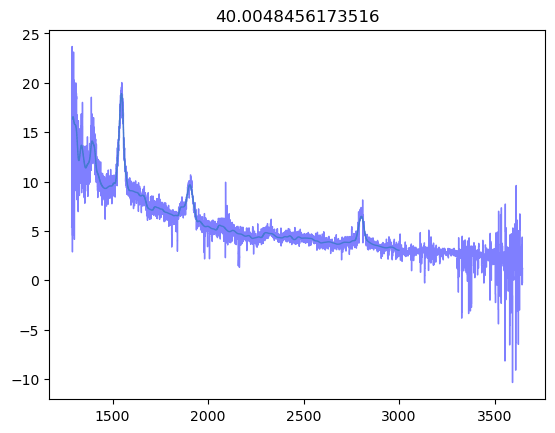

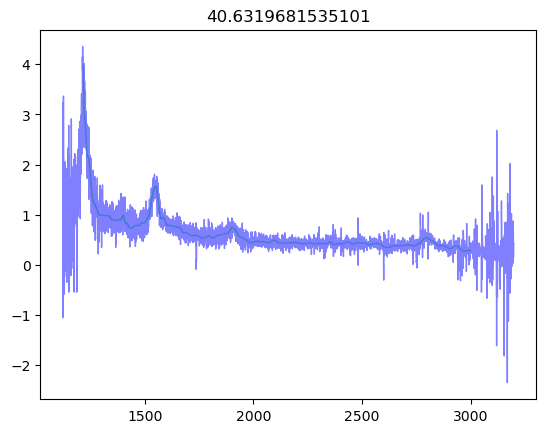

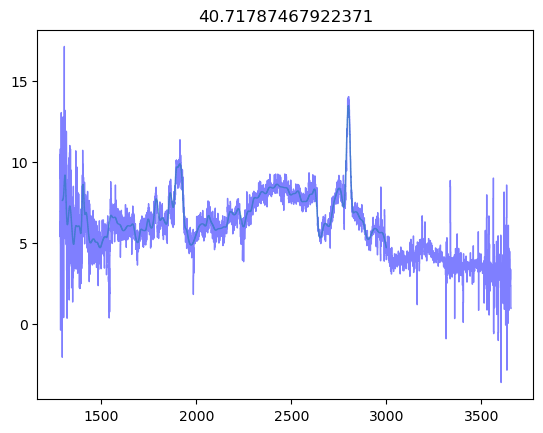

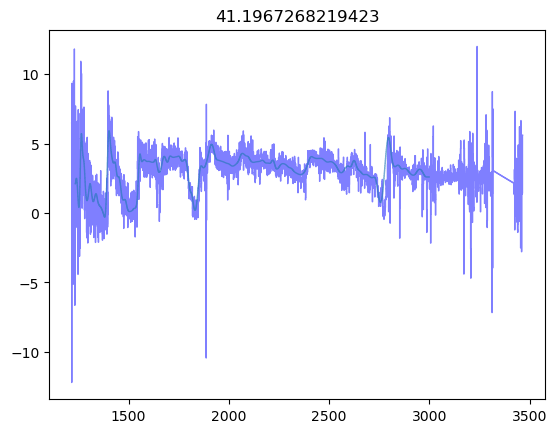

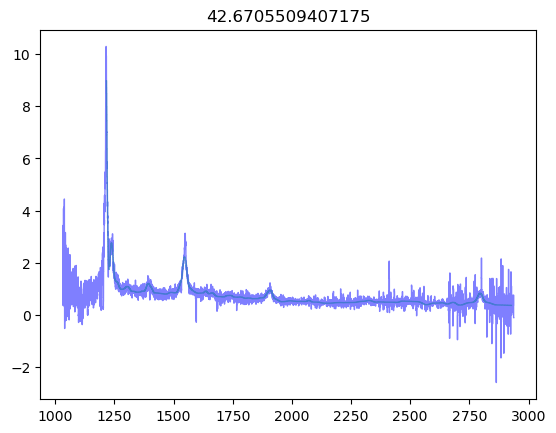

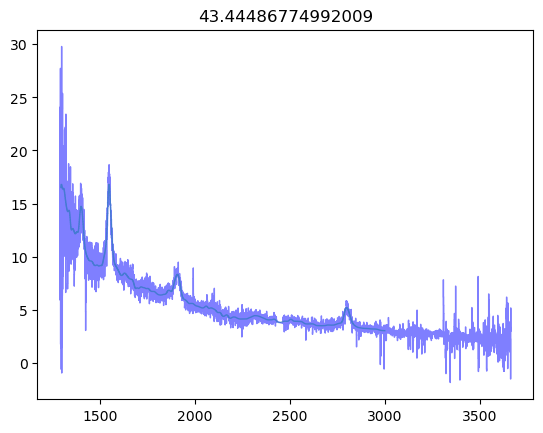

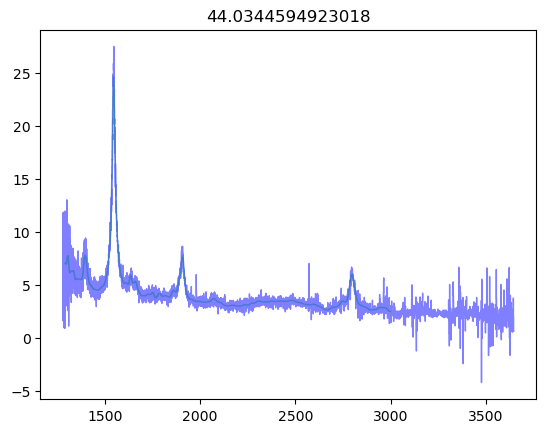

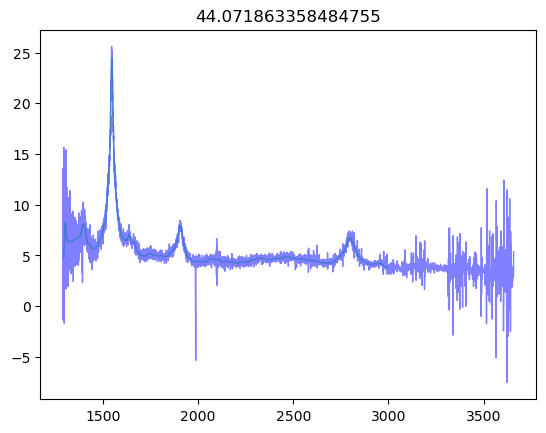

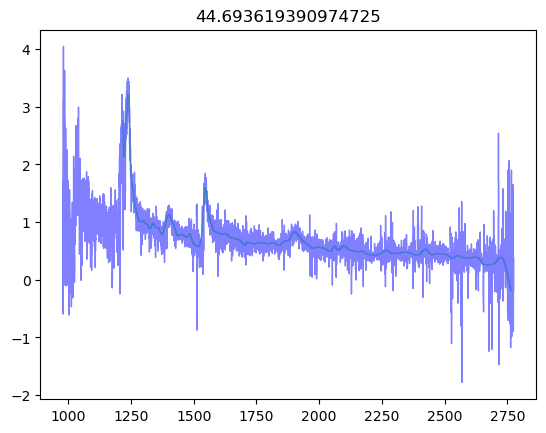

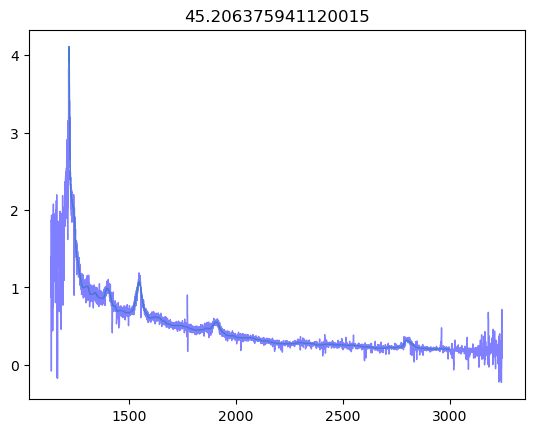

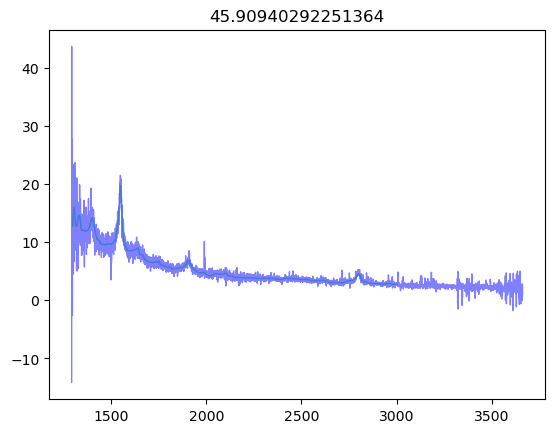

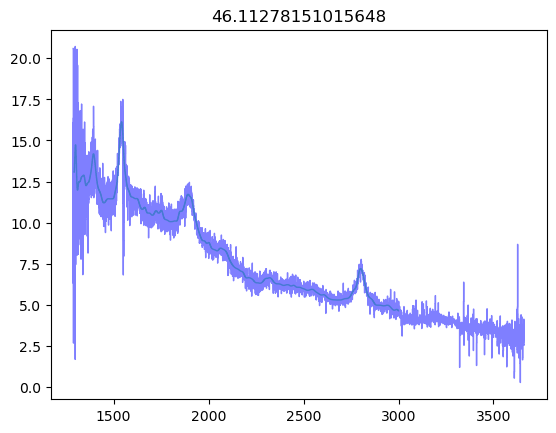

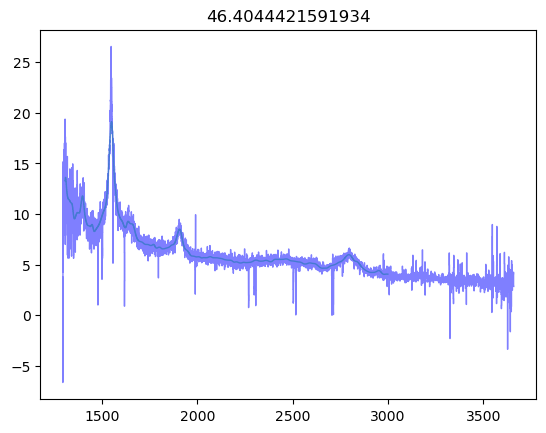

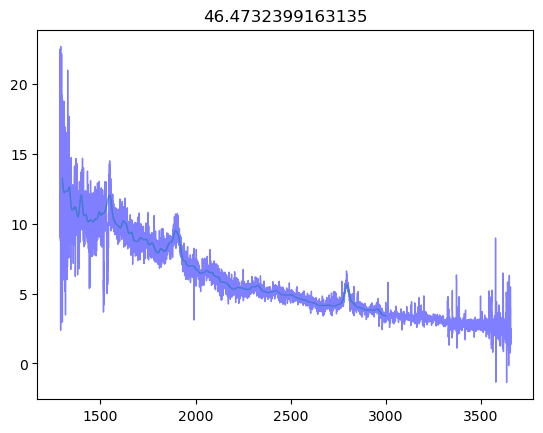

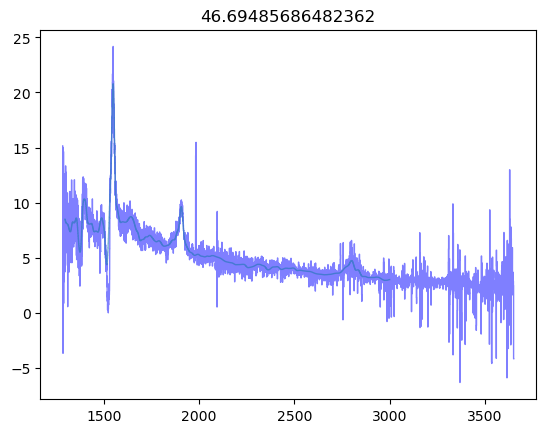

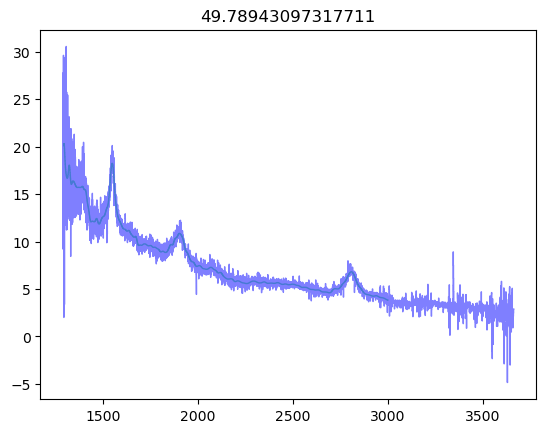

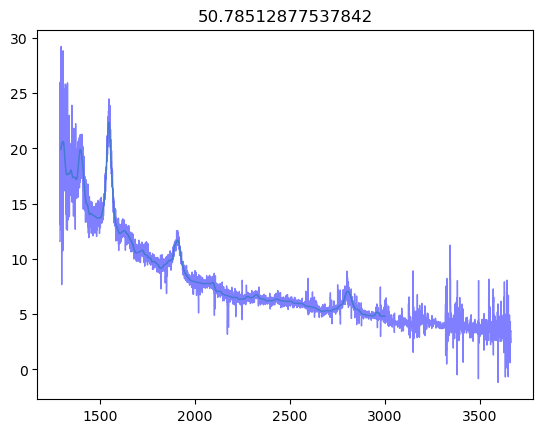

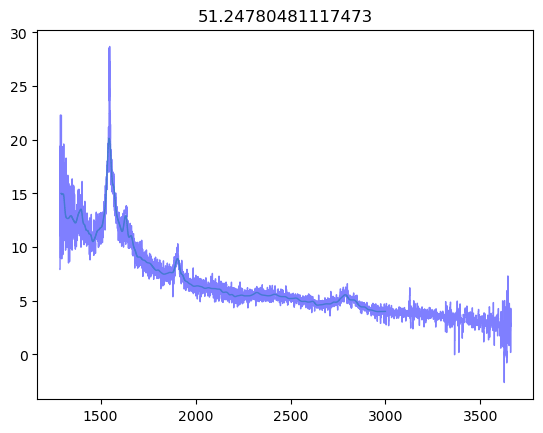

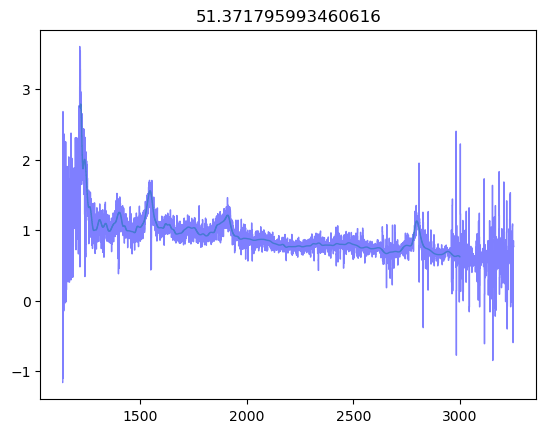

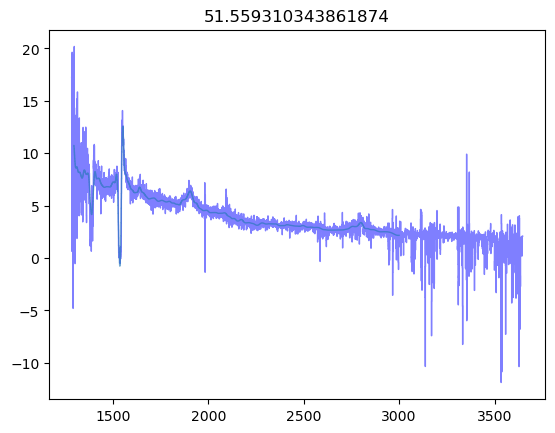

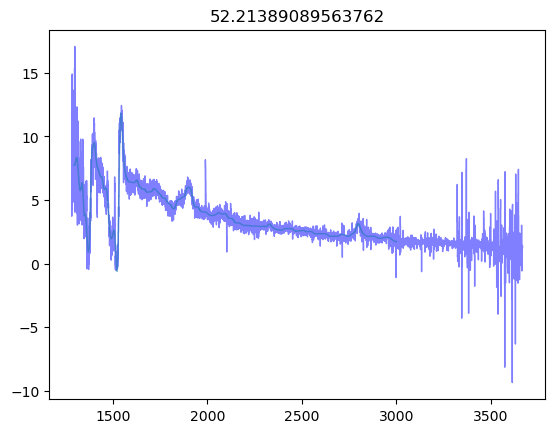

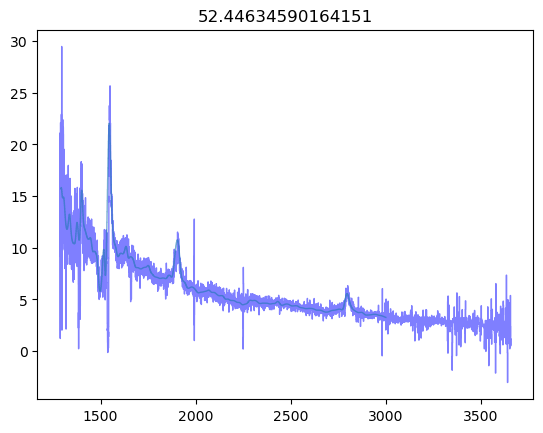

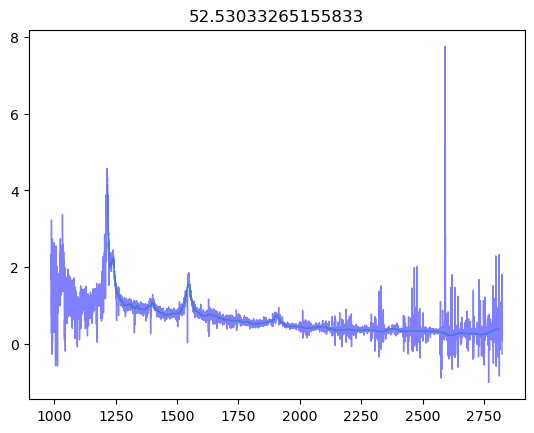

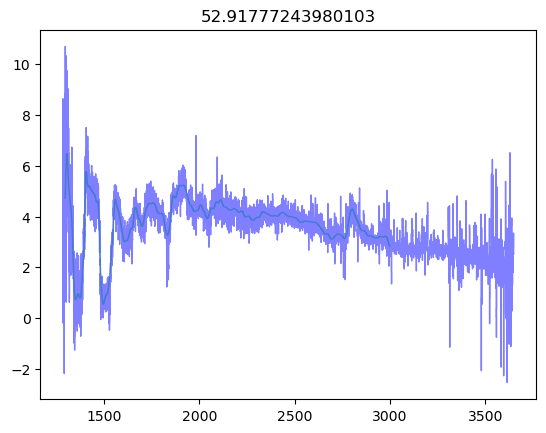

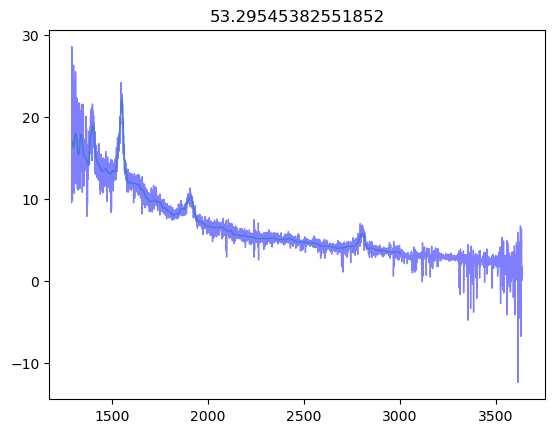

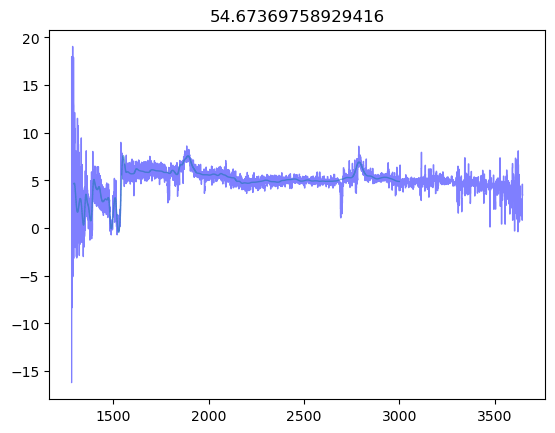

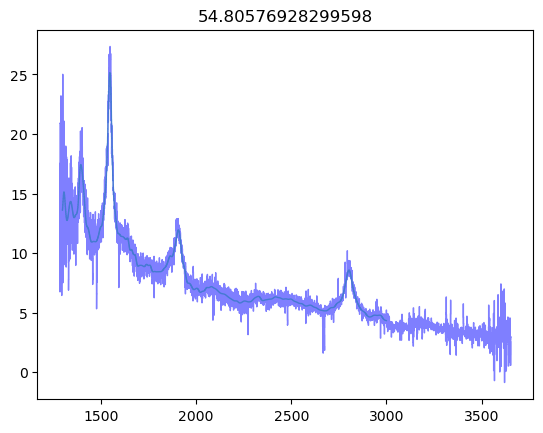

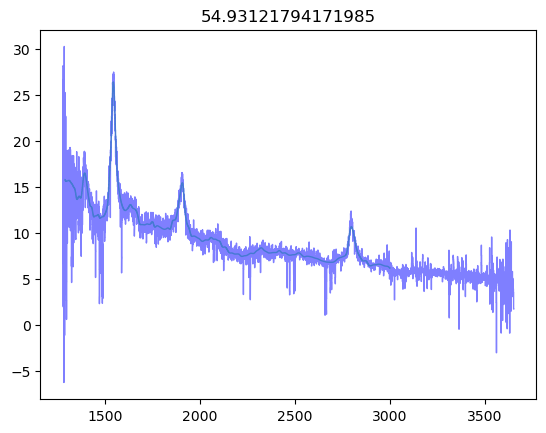

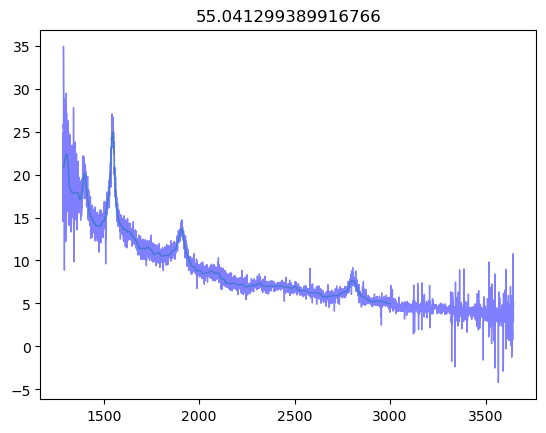

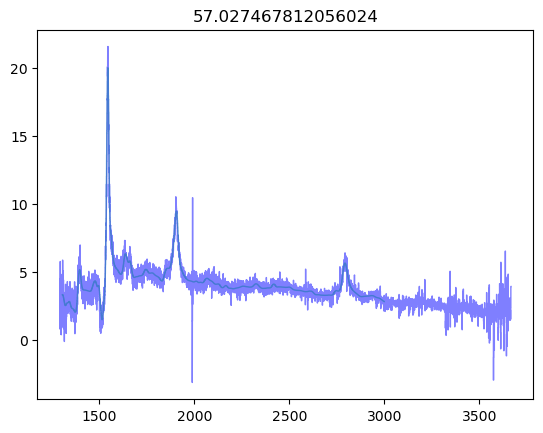

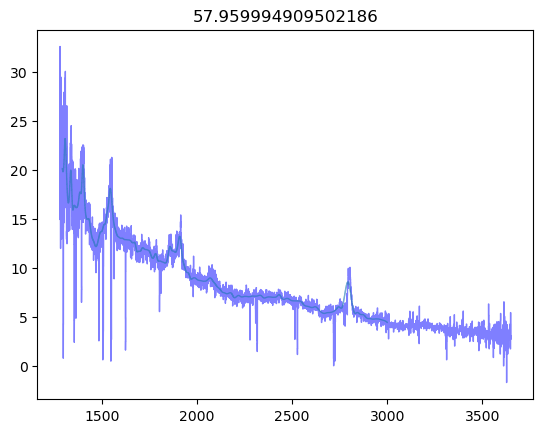

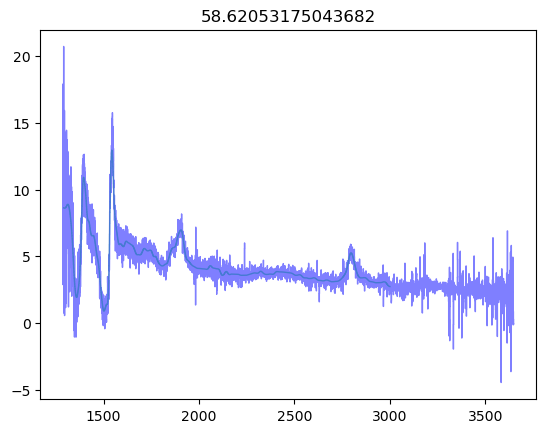

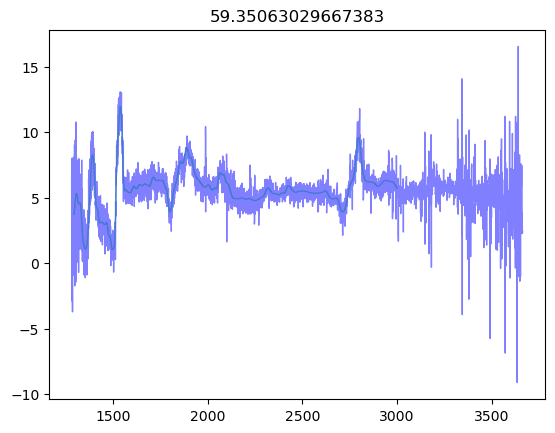

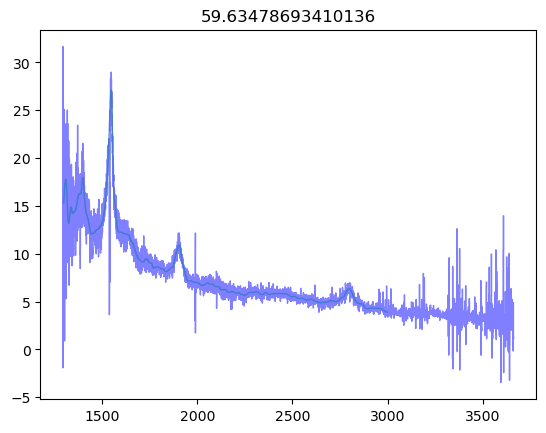

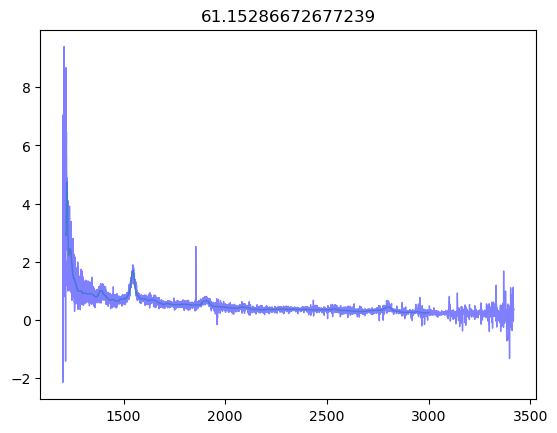

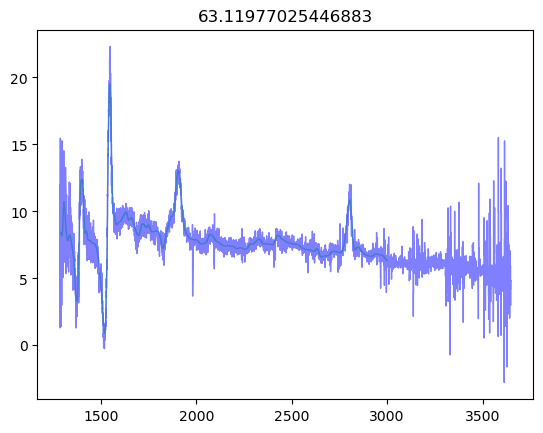

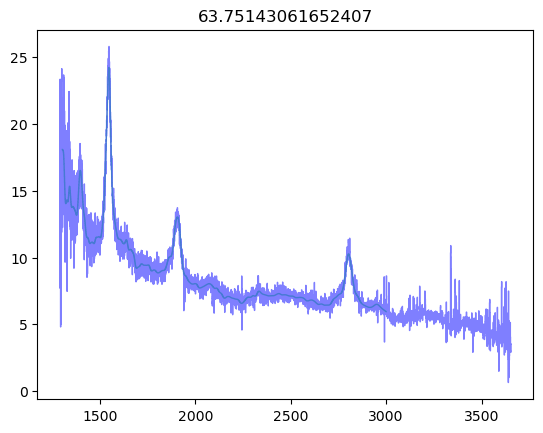

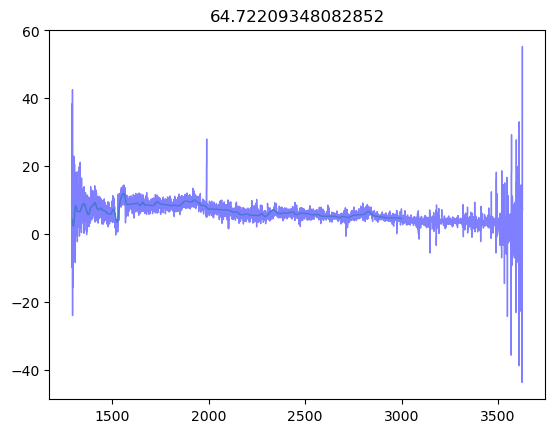

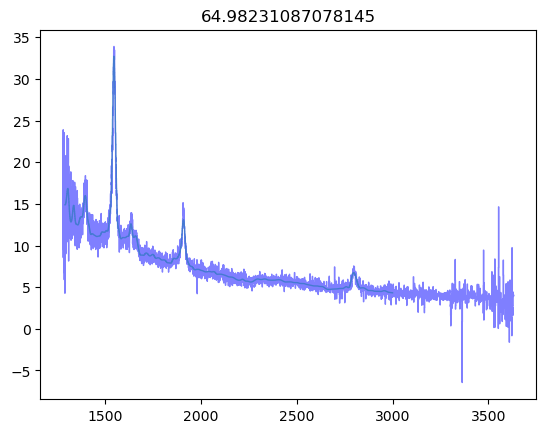

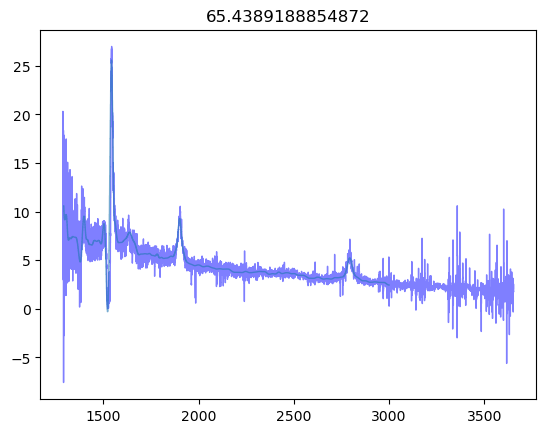

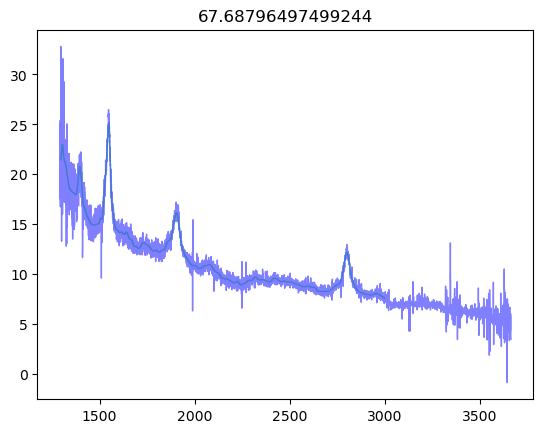

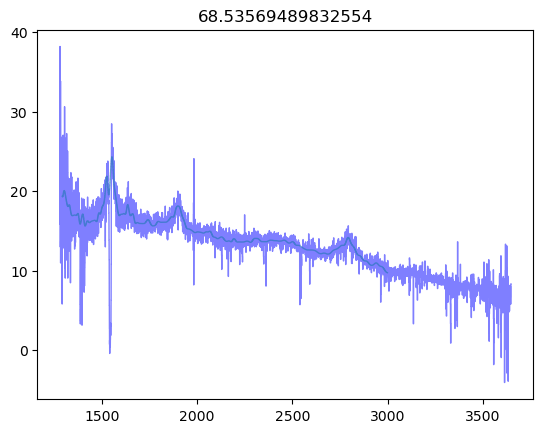

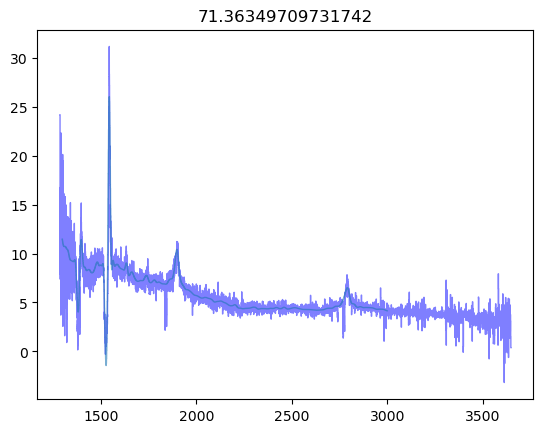

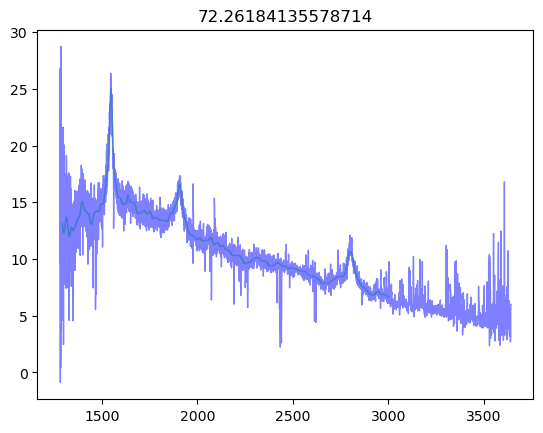

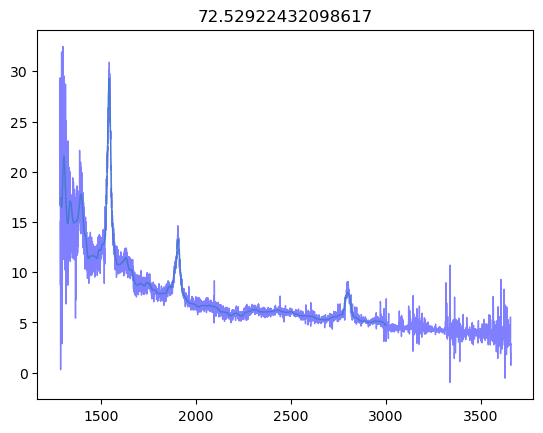

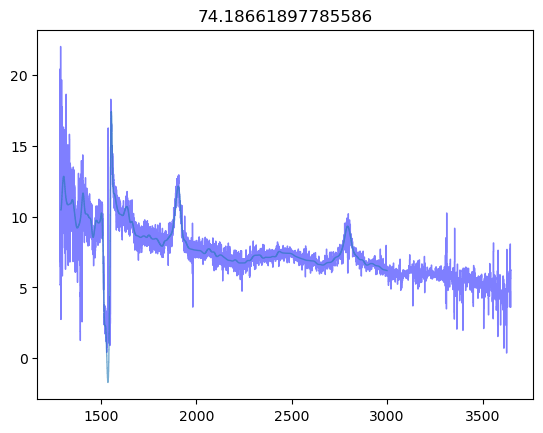

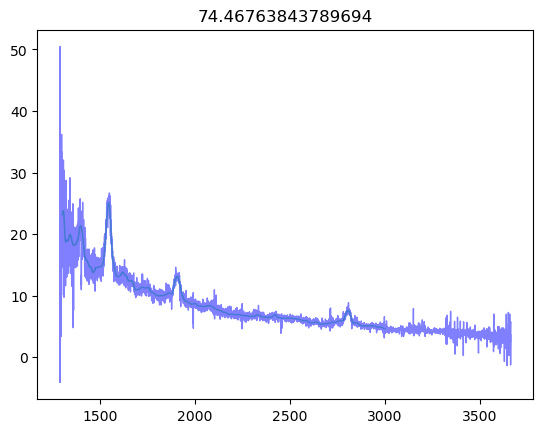

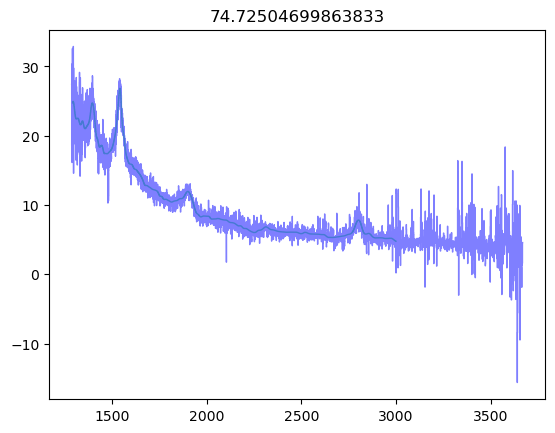

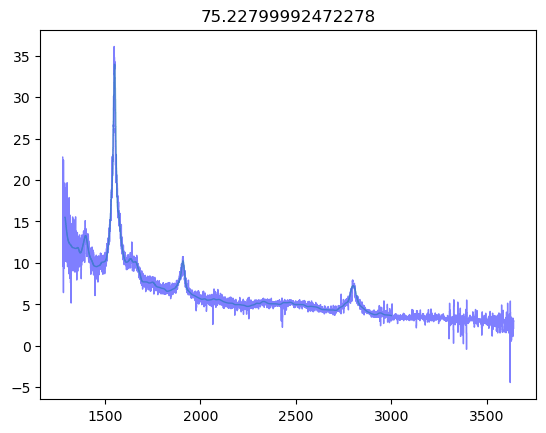

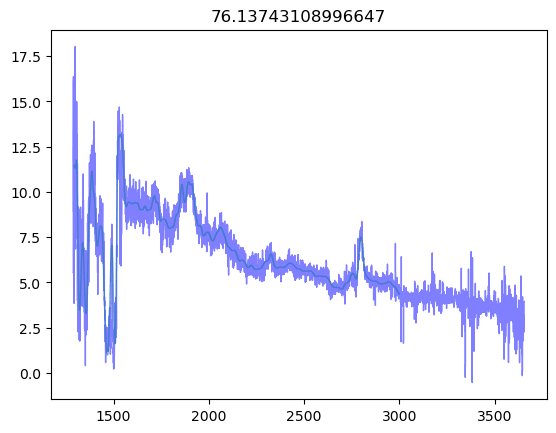

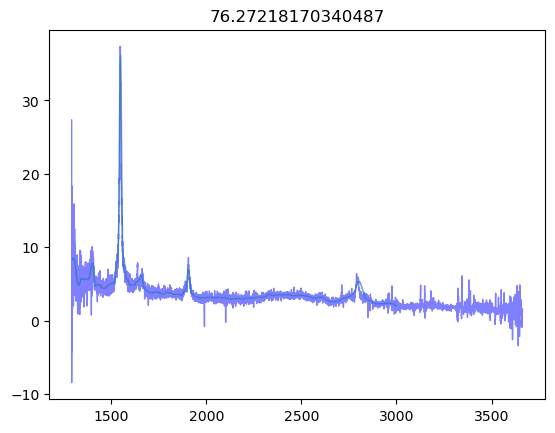

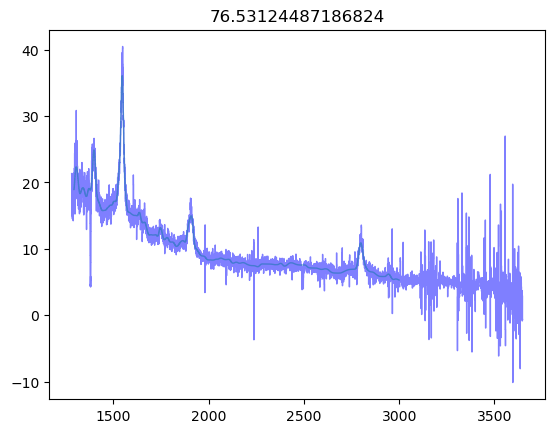

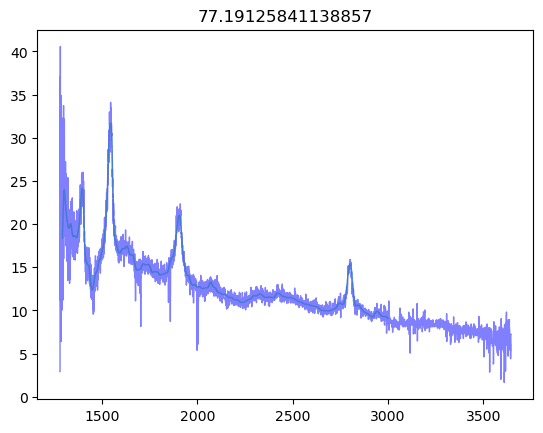

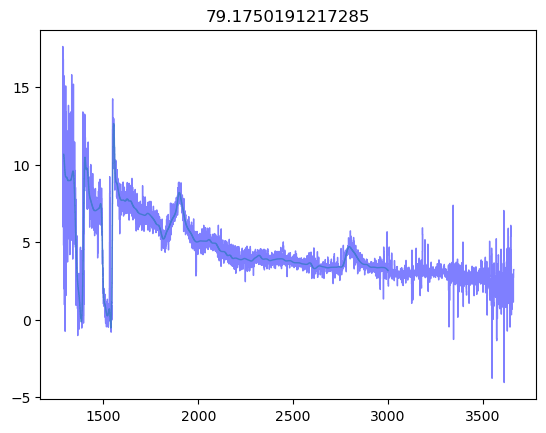

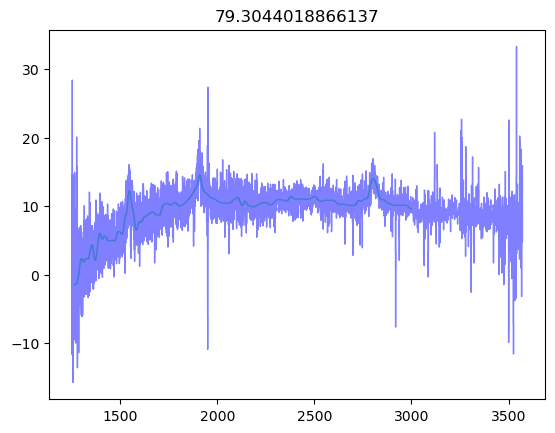

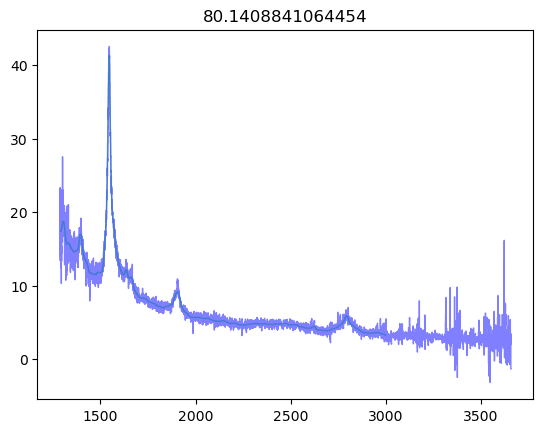

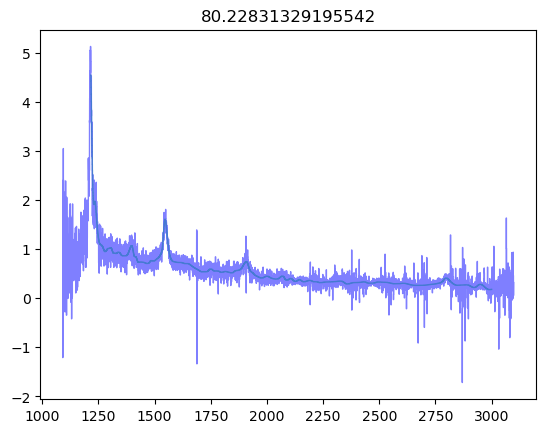

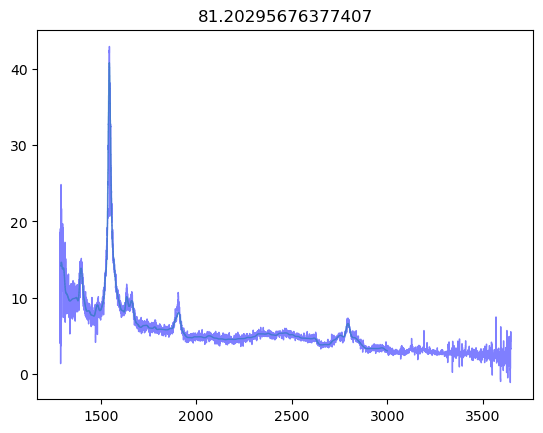

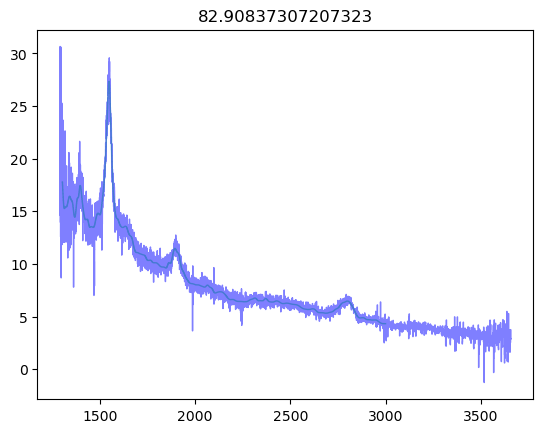

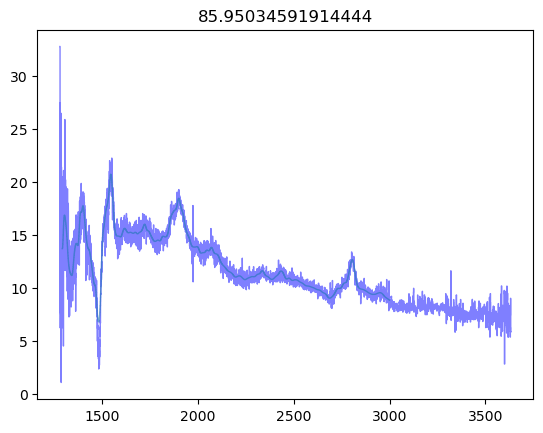

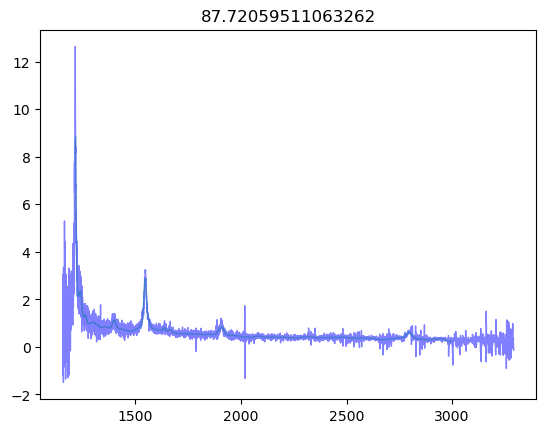

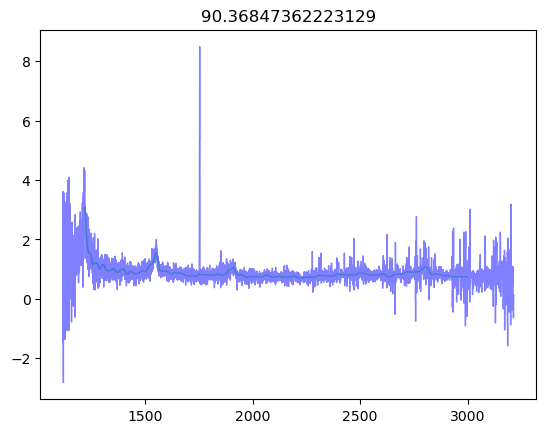

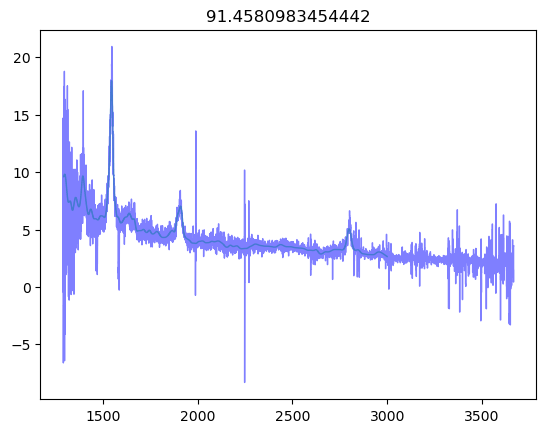

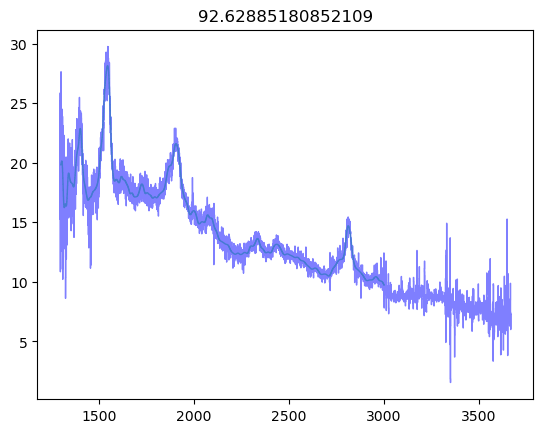

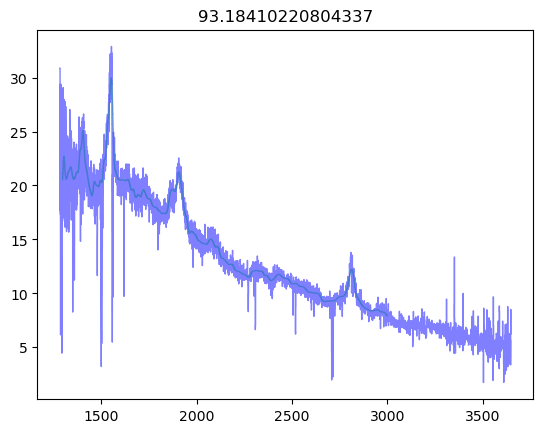

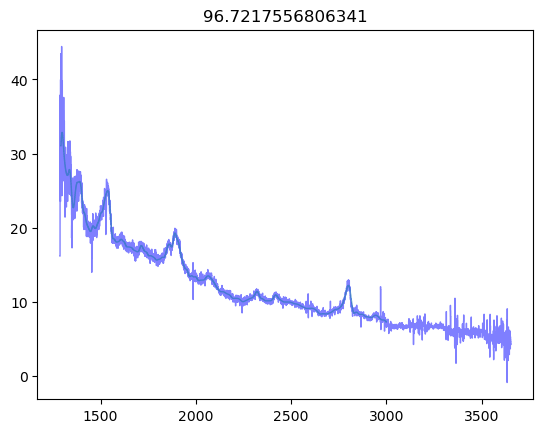

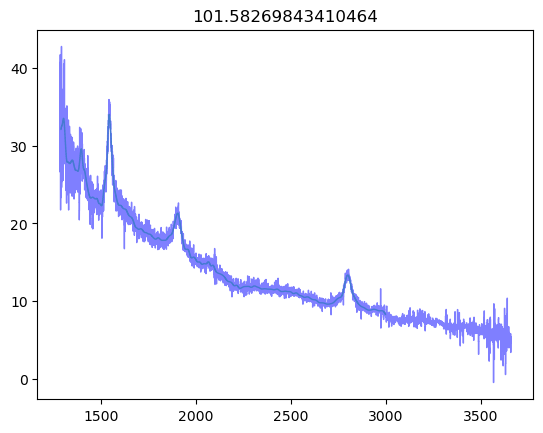

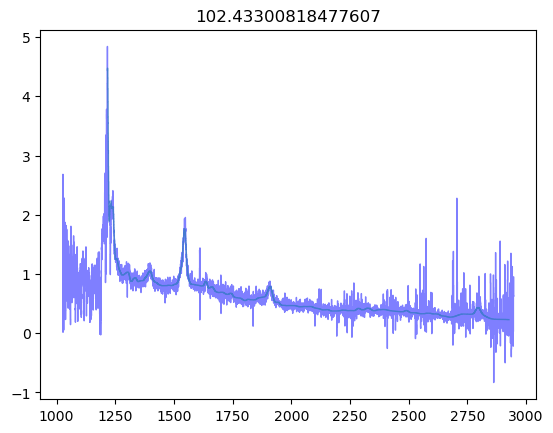

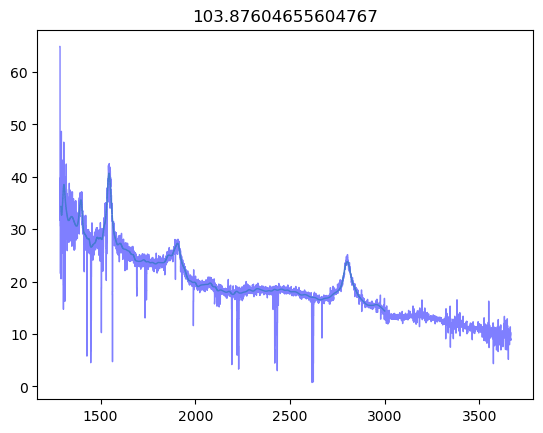

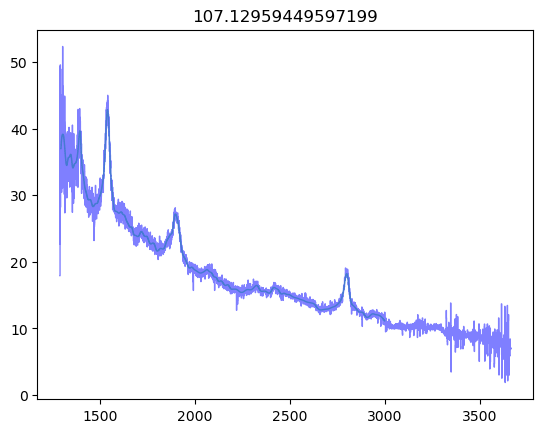

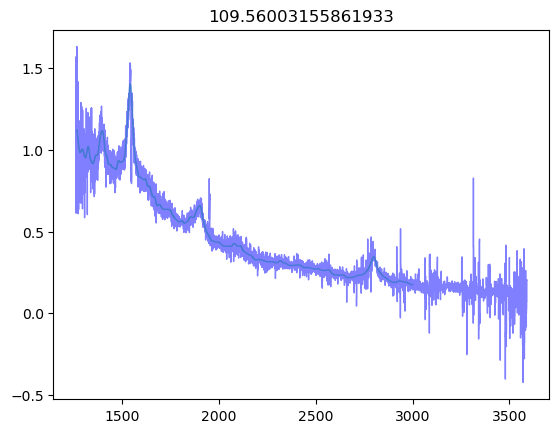

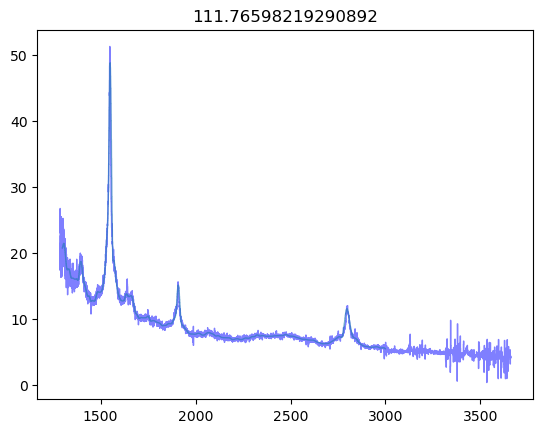

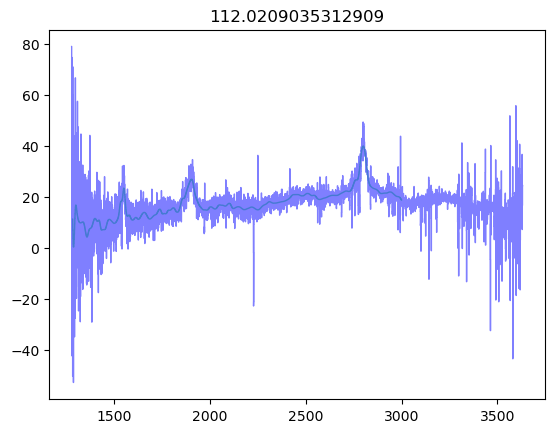

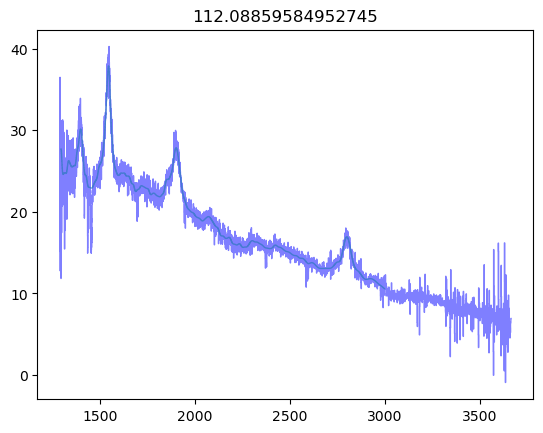

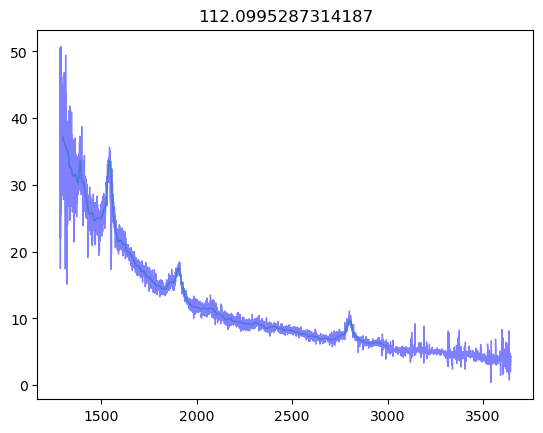

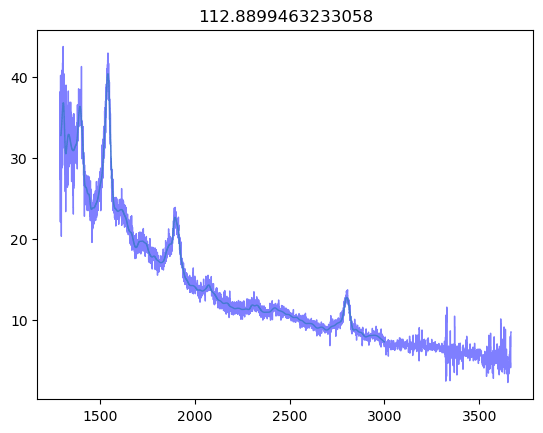

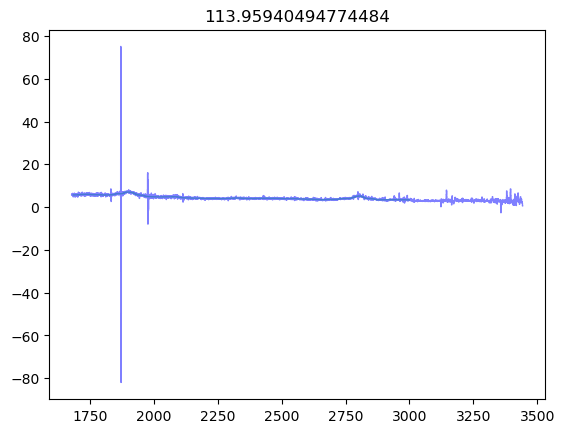

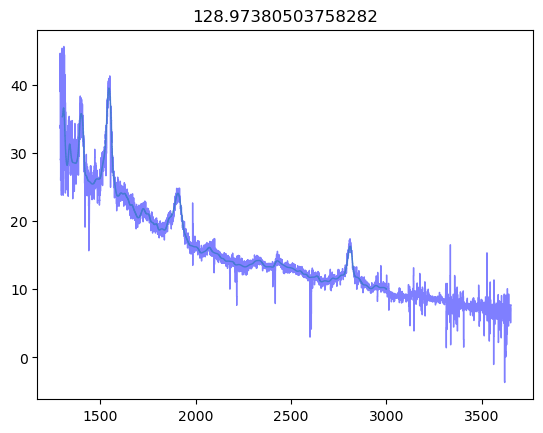

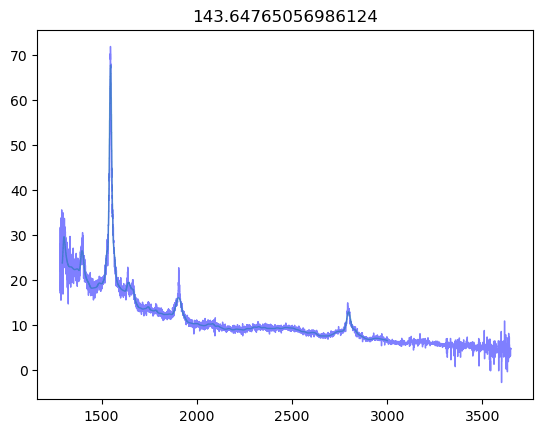

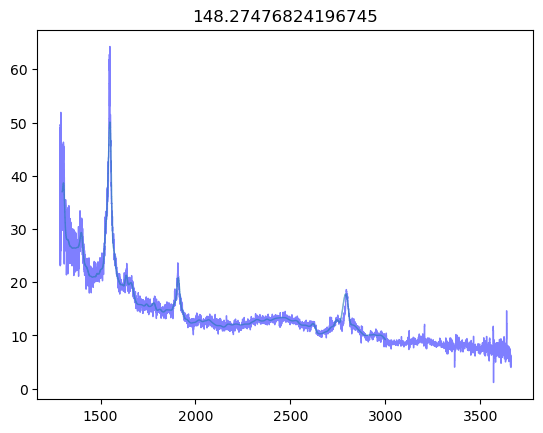

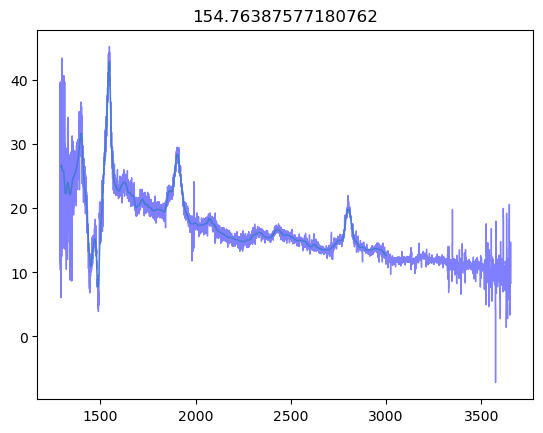

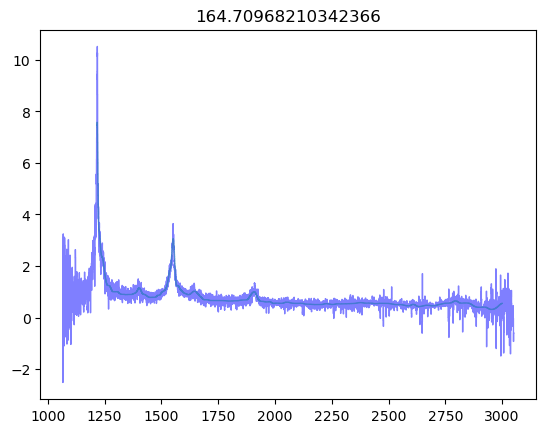

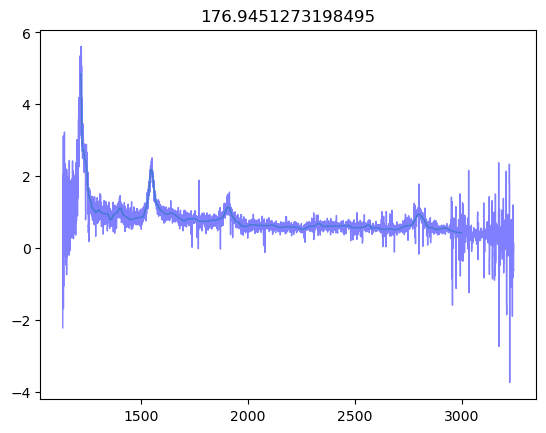

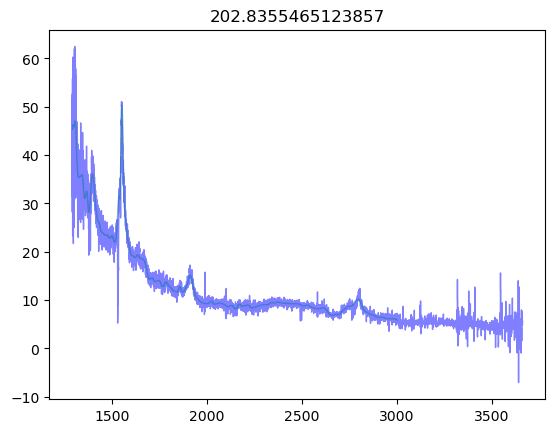

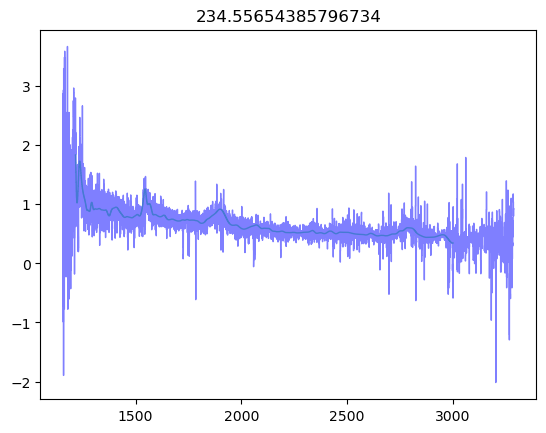

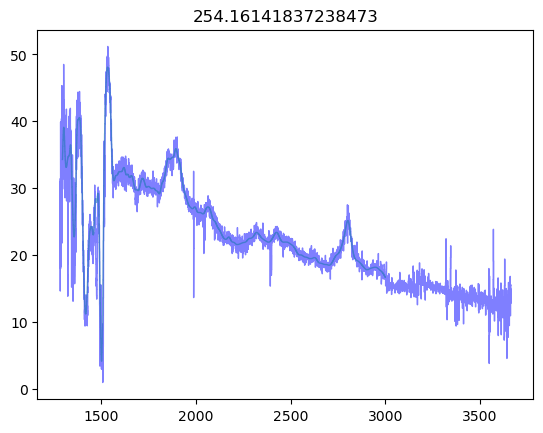

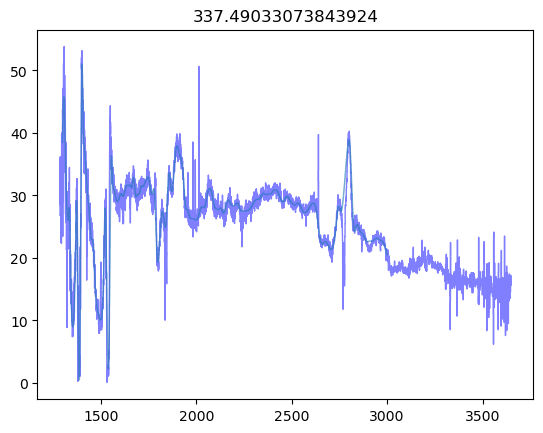

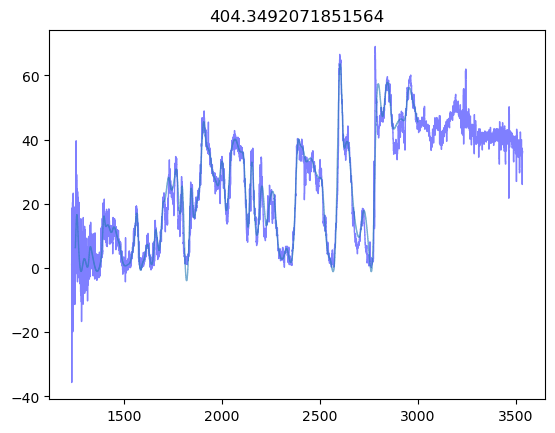

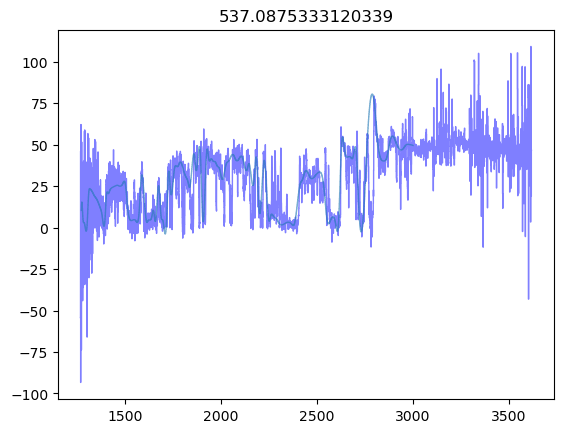

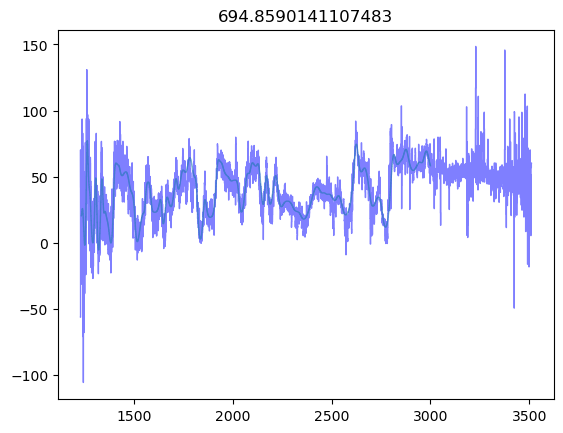

In [50]:
for i,ind in enumerate(nn_q_sorted[-100:]):
    fig,ax=plt.subplots()
    plot_ndata(int(ind),fig,ax,1,False)
    plot_nfit(int(ind),fig,ax,1,False)
    plt.title('{}'.format(nn_dmeans_sorted[-100:][i]))
    plt.show()
    plt.close()

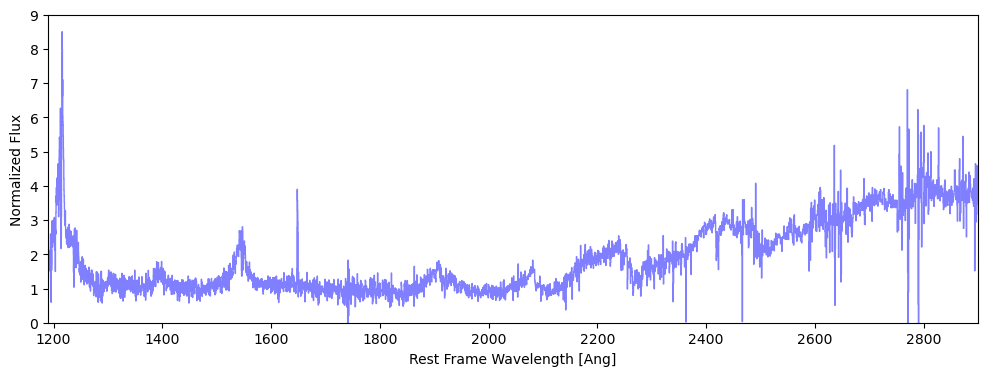

In [62]:
fig,ax=plt.subplots(figsize=(12, 4))
plot_ndata(int(399361),fig,ax,1,False)
# print(nn_dmeans[np.where(nn_q==399361)[0][0]])
plt.xlim(1190,2900)
plt.ylim(0,9)
plt.xlabel('Rest Frame Wavelength [Ang]')
plt.ylabel('Normalized Flux')
plt.show()
plt.close()

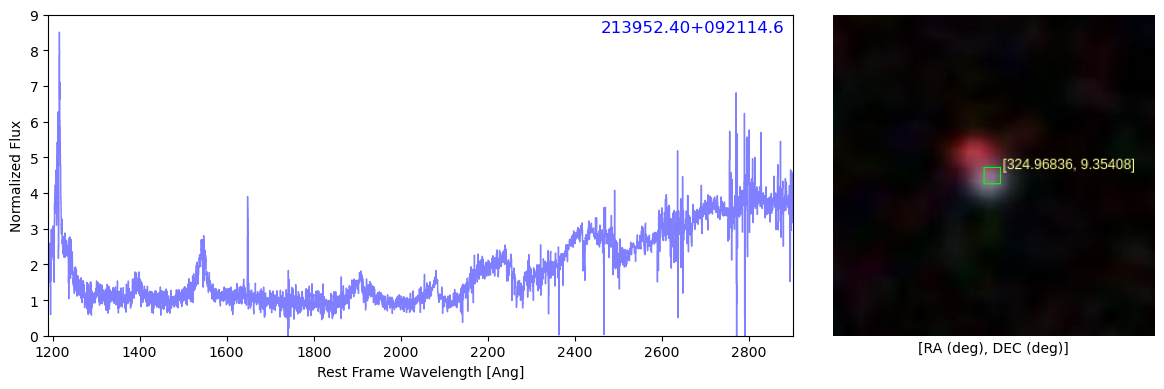

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.gridspec import GridSpec

# Create a plot (e.g., a sine wave plot)
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Load an image
img = Image.open('/home/bartosz/Projects/BOSS/plots/add_plots/Navigate - SkyserverSDSS.png')

# Create a figure
fig = plt.figure(figsize=(12, 4))

# Define a GridSpec with 1 row and 2 columns, and set the width ratio
gs = GridSpec(1, 2, width_ratios=[2, 1])  # Adjust width ratios: 2 parts for the plot, 1 part for the image

# Create the first subplot for the plot
ax1 = fig.add_subplot(gs[0])
plot_ndata(int(399361),fig,ax1,1,False)
ax1.text(2880,8.5,'213952.40+092114.6',color='blue',ha='right',size='large')
ax1.set_xlim(1190,2900)
ax1.set_ylim(0,9)
ax1.set_xlabel('Rest Frame Wavelength [Ang]')
ax1.set_ylabel('Normalized Flux')
# Create the second subplot for the image
ax2 = fig.add_subplot(gs[1])
ax2.imshow(img)
ax2.set_xlabel('[RA (deg), DEC (deg)]') #r'Taken from: skyserver.sdss.org/dr18/VisualTools/navi/')
# ax2.axis('off')  # Turn off axis for the image
# Hide the axis spines (lines)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Remove ticks
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_yticks([])  # Remove y-axis ticks

# Show the figure with the plot and the image
plt.tight_layout()
plt.savefig('plots/add_plots/photobomb.pdf',bbox_inches='tight')
plt.show()